In [1]:
import os, logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helpers import get_ip_address, has_write_permission, SNPDataSet

### Set variables

In [2]:
data_locations = {
    '223.195.111.48': '/project/datacamp/team11/data',
    '147.47.44.229': '/home/jinhyun/data/1kGP',
}

chr_list = [str(x) for x in range(1,23)]
gt_dict = {"0|0" :0, "0|1" : 1, "1|0" : 2, "1|1" : 3 } # genotype dict for converting string-> inteter 

### Validation checks

In [3]:
raw_data_path = data_locations.get(get_ip_address(), '/not_found')
sample_annotation_file = os.path.join(raw_data_path, "igsr-1000 genomes 30x on grch38.tsv")
preprocess_path = os.path.join(raw_data_path, "preprocessed")

assert os.path.exists(preprocess_path), f"Data path not exists: {raw_data_path} OR IP setting is incorrect: {get_ip_address()}"
assert os.path.isfile(sample_annotation_file), f"File not exists : {sample_annotation_file}"
assert has_write_permission(preprocess_path), f"You do not have write permission for {preprocess_path}"

In [4]:
sample_annotation_df = pd.read_csv(sample_annotation_file, sep="\t")
print(f"Read sample annotation info with shape : {sample_annotation_df.shape}")

Read sample annotation info with shape : (3202, 9)


### data loading

In [5]:
target_data_file_prefix = os.path.join(preprocess_path, "merged_random_100k") #merged_filtered

In [6]:
snp_dataset = SNPDataSet.from_file(target_data_file_prefix, sample_annotation_df)

print(f"\ngenotype array shape (#samples, #features) : {snp_dataset.genotype_array.shape}")
print(f"sample annotations (#samples, ) : {snp_dataset.sample_annotation_df.shape}")
print(f"variant info dataframe (#features, ): {snp_dataset.variant_info_df.shape}")

Reading data from files /home/jinhyun/data/1kGP/preprocessed/merged_random_100k_matrix.npy and /home/jinhyun/data/1kGP/preprocessed/merged_random_100k_variant.csv
Read genotype array of shape (3202, 100000) and variant info dataframe of shape (100000, 4)

genotype array shape (#samples, #features) : (3202, 100000)
sample annotations (#samples, ) : (3202, 9)
variant info dataframe (#features, ): (100000, 4)


### Supporting sample count filtering

In [ ]:
supporting_sample_count = (snp_dataset.genotype_array != 0).sum(axis = 0)

In [ ]:
sns.histplot(supporting_sample_count / snp_dataset.genotype_array.shape[0], bins=100, kde=True)  # 'bins' controls the number of bins, 'kde' adds a Kernel Density Estimate plot

#plt.xscale('log')
#plt.xlim(xmin, xmax)

plt.title('Histogram of Data')
plt.xlabel('Population Allele Frequency')
plt.ylabel('Frequency')

plt.show()

In [ ]:
supporting_count_filter = supporting_sample_count > 5
print(f"This filter will retain {supporting_count_filter.sum()} /", snp_dataset.genotype_array.shape[1], "variants")

In [ ]:
snp_dataset.filter_variant(supporting_count_filter, inplace = True)

In [ ]:
snp_dataset.save_data(os.path.join(preprocess_path, "merged_filtered"))

### 0 filtering

In [ ]:
threshold = 0.0005
zero_ratio = (snp_dataset.genotype_array == 0).sum(axis=0) / snp_dataset.genotype_array.shape[0]

zero_filter = zero_ratio <= threshold
print(f"This filter will retain {zero_filter.sum()} /", snp_dataset.genotype_array.shape[1], "variants")


In [ ]:
snp_dataset.filter_variant(zero_filter, inplace = True)
snp_dataset.save_data(os.path.join(preprocess_path, "merged_zerofilter"))

### Random filteration

In [ ]:
n_random_selection = 100

num_snps = snp_dataset.genotype_array.shape[1]
random_selection_filter = np.zeros(num_snps, dtype=bool)
np.random.seed(1004)
selected_indices = np.random.choice(num_snps, n_random_selection, replace=False)
random_selection_filter[selected_indices] = True
print(f"This filter will retain {random_selection_filter.sum()} /", snp_dataset.genotype_array.shape[1], "variants")

#snp_dataset_filtered = snp_dataset.filter_variant(random_selection_filter, inplace = False)
snp_dataset.filter_variant(random_selection_filter, inplace = True)

In [ ]:
snp_dataset.save_data(os.path.join(preprocess_path, "merged_random_100"))

### annotation analysis

In [9]:
sample_annotation_df["Superpopulation code"].value_counts()
# sample_annotation["Population name"].value_counts()

Superpopulation code
AFR        893
EUR        632
SAS        601
EAS        585
AMR        490
EUR,AFR      1
Name: count, dtype: int64

### dimension reduction by PCA and t_SNE

In [10]:
genotype_array_onehot = snp_dataset.create_onehot_genotype_array(inplace = False, batch_initialize = False)
print(snp_dataset.genotype_array.shape, genotype_array_onehot.shape)

(3202, 100000) (3202, 100000, 2)


In [11]:
#del snp_dataset

In [12]:
# define data and label for PCA and t-SNE
data_array = genotype_array_onehot.reshape(genotype_array_onehot.shape[0], -1) #flatten last feature dims
labels = np.array(snp_dataset.sample_annotation_df["Population name"]) #Population name #Superpopulation code

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [14]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_array)

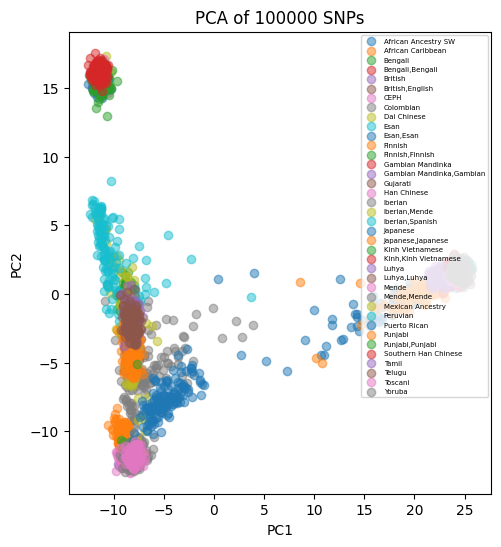

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label, alpha=0.5)
plt.title(f'PCA of {snp_dataset.genotype_array.shape[1]} SNPs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc=1, prop={'size': 5})

plt.show()


In [16]:
# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1)
tsne_result = tsne.fit_transform(data_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3202 samples in 0.302s...
[t-SNE] Computed neighbors for 3202 samples in 34.655s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3202
[t-SNE] Computed conditional probabilities for sample 2000 / 3202
[t-SNE] Computed conditional probabilities for sample 3000 / 3202
[t-SNE] Computed conditional probabilities for sample 3202 / 3202
[t-SNE] Mean sigma: 7.739023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.904442
[t-SNE] KL divergence after 1000 iterations: 1.820645


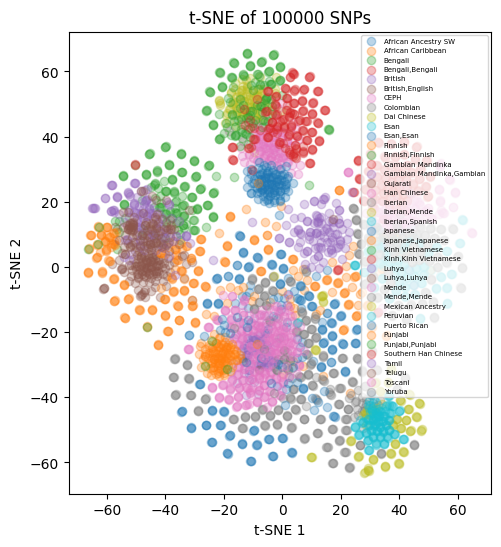

In [24]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
labels_unique = np.unique(labels)
colors = cm.viridis(np.linspace(0, 1, len(labels_unique)))  # Using viridis colormap

for label, color in zip(labels_unique, colors):
    indices = np.where(labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=label, alpha=0.3,
                #color=color,
                ) 

plt.title(f't-SNE of {snp_dataset.genotype_array.shape[1]} SNPs')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(loc=1, prop={'size': 5})

plt.show()

In [41]:
import subprocess
def annotate_variant(snp_dataset, save_path, annovar_path = "/home/jinhyun/tools/annovar"):
    avinput_file_name = os.path.join(save_path, "temp.avinput")
    annotate_file_prefix = os.path.join(save_path, "temp")
    annotate_file_name = f"{annotate_file_prefix}.hg38_multianno.txt"

    avinput_df = snp_dataset.variant_info_df.copy(deep= True).rename(columns = {"POS" : "START"})
    avinput_df["END"] = avinput_df["START"]
    avinput_df[['CHROM', 'START', 'END', 'REF', 'ALT']].to_csv(avinput_file_name, sep='\t', index=False, header=False)

    
    cmd = f"{annovar_path}/table_annovar.pl {avinput_file_name} {annovar_path}/humandb -buildver hg38 -out {annotate_file_prefix} -remove -protocol refGene,dbnsfp42c -operation g,f -nastring . "
    print("Performing annovar...")
    ret = subprocess.run(cmd, shell=True, text=True, capture_output=True)
    os.remove(avinput_file_name)

    try:
        annotated_df = pd.read_csv(annotate_file_name, sep = "\t", header = 0, na_values=["."], dtype = str)
        os.remove(annotate_file_name)
        print(f"read ANNOVAR annotated result of shape {annotated_df.shape}")
    except:
        print("[warn] could not read annovar result.")
        return None
    
    return(annotated_df)
    
    


In [42]:
a = annotate_variant(snp_dataset, save_path=preprocess_path)

Performing annovar...
read ANNOVAR annotated result of shape (100000, 100)


,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,phyloP30way_mammalian_rankscore,phastCons100way_vertebrate,phastCons100way_vertebrate_rankscore,phastCons30way_mammalian,phastCons30way_mammalian_rankscore,SiPhy_29way_logOdds,SiPhy_29way_logOdds_rankscore,Interpro_domain,GTEx_V8_gene,GTEx_V8_tissue
0,chr1,29280,29280,C,A,ncRNA_intronic,WASH7P,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,59615,59615,C,T,intergenic,FAM138A;OR4F5,dist=23534;dist=9476,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,61952,61952,C,A,intergenic,FAM138A;OR4F5,dist=25871;dist=7139,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,133433,133433,C,T,intergenic,OR4F5;LOC729737,dist=63425;dist=1340,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,135397,135397,G,A,ncRNA_exonic,LOC729737,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,chr22,50756774,50756774,C,A,upstream,RPL23AP82,dist=312,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,chr22,50762049,50762049,G,A,ncRNA_intronic,RPL23AP82,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,chr22,50771924,50771924,T,A,ncRNA_intronic,RPL23AP82,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,chr22,50781033,50781033,A,C,ncRNA_intronic,RPL23AP82,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
a = np.array([[0,1,2,3], [2,3,0,1]])
v = pd.DataFrame([["a", "b"], ["c", "d"], ["e", "f"], ["g", "h"]])
data = SNPDataSet(a,v,sample_annotation_df[:2])


In [ ]:
t1 = data.create_onehot_genotype_array(batch_initialize=False)
t2 = data.create_onehot_genotype_array(batch_initialize=True)
print((t1 == t2).all())

In [ ]:
i,j = 1,0
print(data.genotype_array[i,j], t1[i,j])